In [ ]:
# Import statements and main classes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pickle
from celara import KeplerLCPreprocessor, KeplerFeatureExtractor
from celara_utils import fetch_lightcurves

# 1.Download Data (KOI, Lightcurves)

In [ ]:
# Download KOI (Kepler Objects of Interest ie stars) catalog from NASA Exoplanet Archive using TAP service
url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+q1_q17_dr25_koi&format=csv"
data_path = "data/"
koi_df = pd.read_csv(url)

# Save locally for reuse
koi_df.to_csv(f"{data_path}/kepler_koi_dr25.csv", index=False)
koi_df.head()

In [6]:
# Keep only confirmed planets and false positives
koi_df = koi_df[koi_df["koi_disposition"].isin(["CONFIRMED", "FALSE POSITIVE"])].copy()

# Map to numeric labels
label_map = {"CONFIRMED": 1, "FALSE POSITIVE": 0}
koi_df["label"] = koi_df["koi_disposition"].map(label_map)

print(koi_df["koi_disposition"].value_counts())
print("Labeled dataset ready, shape:", koi_df.shape)

koi_disposition
FALSE POSITIVE    3965
CONFIRMED         2729
Name: count, dtype: int64
Labeled dataset ready, shape: (6694, 154)


In [ ]:
# Download light curves. Warning. This might take long.
# subset = koi_df.sample(50, random_state=42)
# subset.to_csv("data/koi_subset.csv", index=False)
# subset_results = fetch_lightcurves(subset["kepid"].tolist(), overwrite=False)
# print(subset_results["success"].value_counts())
# print(subset_results['error'].value_counts())


Processing KIC 004570949
Raw data points: 1626
After cleaning: 1624 points
Normalized by factor: 64649
Detrended with window: 201


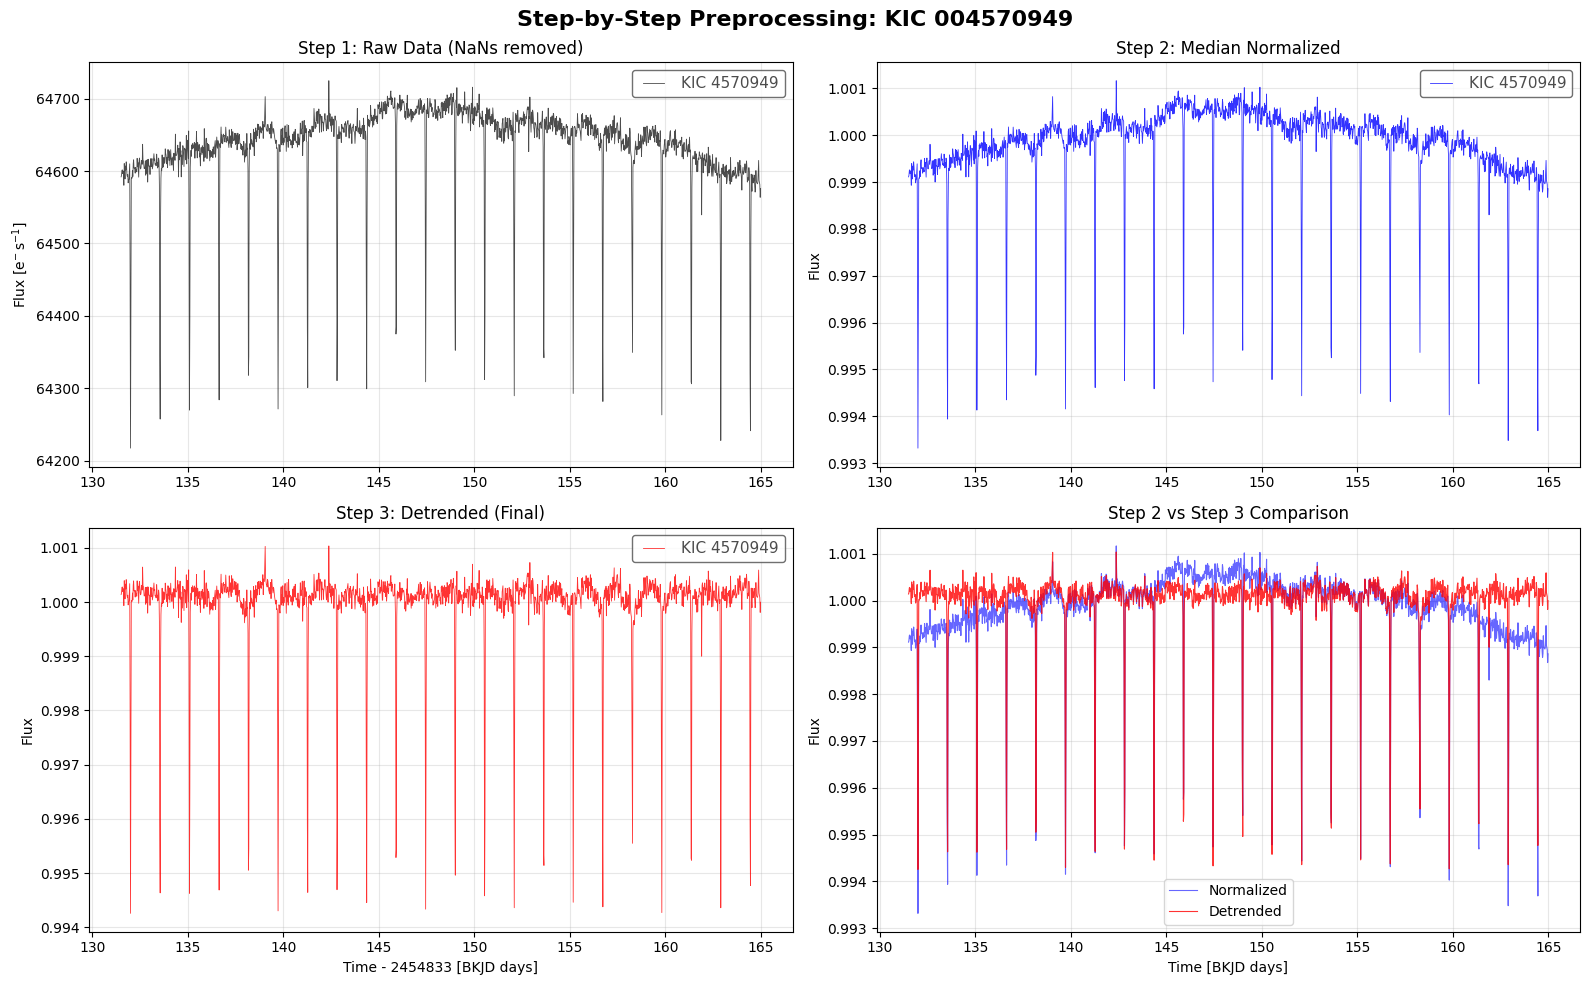


=== Full Single Method Processing ===
Single method result: 1624 points
Max difference between methods: 0.00e+00 (should be ~0)

=== Processing Statistics ===
Original flux std: 58.542679
Normalized flux std: 0.000906
Detrended flux std: 0.000801
Methods identical: True


In [9]:
# EXAMPLE: Step-by-Step Preprocessing with Individual Methods + Plotting
preprocessor = KeplerLCPreprocessor(detrend_window=201)

# Select a representative light curve file (using existing file)
file_path = "data/lightcurves/mastDownload/Kepler/kplr004570949_lc_Q011111011101110111/kplr004570949-2009166043257_llc.fits"

# Extract KIC identifier
kic_id = preprocessor.extract_kic_id(file_path)
print(f"Processing {kic_id}")

# Read raw light curve
lc_raw = preprocessor.read_lc_file(file_path)
print(f"Raw data points: {len(lc_raw.time)}")

# =============================================================================
# STEP-BY-STEP PROCESSING WITH PLOTS
# =============================================================================

# Step 1: Clean (remove NaNs)
lc_step1 = preprocessor.remove_nans(lc_raw)
print(f"After cleaning: {len(lc_step1.time)} points")

# Step 2: Normalize 
lc_step2 = preprocessor.normalize_flux(lc_step1)
median_flux = np.median(lc_raw.flux.value)
print(f"Normalized by factor: {median_flux:.0f}")

# Step 3: Detrend
lc_step3 = preprocessor.detrend_flux(lc_step2, window=201)
print(f"Detrended with window: 201")

# Create comprehensive step-by-step visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(f'Step-by-Step Preprocessing: {kic_id}', fontsize=16, fontweight='bold')

# Plot 1: Raw/Cleaned data
lc_step1.plot(ax=axes[0,0], color='black', alpha=0.7, linewidth=0.6)
axes[0,0].set_title('Step 1: Raw Data (NaNs removed)', fontsize=12)
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_xlabel('')

# Plot 2: Normalized
lc_step2.plot(ax=axes[0,1], color='blue', alpha=0.8, linewidth=0.6)
axes[0,1].set_title('Step 2: Median Normalized', fontsize=12)
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_xlabel('')

# Plot 3: Detrended
lc_step3.plot(ax=axes[1,0], color='red', alpha=0.8, linewidth=0.6)
axes[1,0].set_title('Step 3: Detrended (Final)', fontsize=12)
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Comparison overlay
axes[1,1].plot(lc_step2.time.value, lc_step2.flux.value, 'b-', alpha=0.6, linewidth=0.8, label='Normalized')
axes[1,1].plot(lc_step3.time.value, lc_step3.flux.value, 'r-', alpha=0.8, linewidth=0.8, label='Detrended')
axes[1,1].set_title('Step 2 vs Step 3 Comparison', fontsize=12)
axes[1,1].set_xlabel('Time [BKJD days]')
axes[1,1].set_ylabel('Flux')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# FULL SINGLE METHOD + PLOT
# =============================================================================
print(f"\n=== Full Single Method Processing ===")

# Process using the complete pipeline
lc_full_method = preprocessor.preprocess_single(lc_raw)
print(f"Single method result: {len(lc_full_method.time)} points")

# Verify results are identical
flux_diff = np.abs(lc_step3.flux.value - lc_full_method.flux.value) # type: ignore
print(f"Max difference between methods: {flux_diff.max():.2e} (should be ~0)")


# Print processing statistics
print(f"\n=== Processing Statistics ===")
print(f"Original flux std: {lc_step1.flux.std().value:.6f}")
print(f"Normalized flux std: {lc_step2.flux.std().value:.6f}")
print(f"Detrended flux std: {lc_step3.flux.std().value:.6f}")
print(f"Methods identical: {np.allclose(lc_step3.flux.value, lc_full_method.flux.value)}")

In [ ]:
# BATCH PROCESSING: Using existing KeplerLCPreprocessor and KeplerFeatureExtractor
# This demonstrates how to process multiple lightcurves using the classes from celara.py

# Initialize processors
preprocessor = KeplerLCPreprocessor(detrend_window=201)
feature_extractor = KeplerFeatureExtractor(local_bins=201, global_bins=2001)

# Example: Process all lightcurves in a directory
lightcurve_dir = "data/lightcurves"

if os.path.exists(lightcurve_dir):
    # Get all FITS files
    fits_files = list(Path(lightcurve_dir).rglob('*.fits'))
    print(f"Found {len(fits_files)} FITS files")
    
    # Process first 3 files for demonstration
    demo_files = fits_files[:3]
    print(f"Processing first {len(demo_files)} files...")
    
    # Storage for results
    features_list = []
    labels_list = []
    metadata_list = []
    
    for idx, file_path in enumerate(demo_files, 1):
        try:
            # Extract KIC ID
            kic_id = preprocessor.extract_kic_id(str(file_path))
            kic_number = int(kic_id.replace('KIC ', ''))
            
            print(f"[{idx}] Processing {kic_id}... ", end="")
            
            # Find KOI match
            koi_match = koi_df[koi_df['kepid'] == kic_number]
            if len(koi_match) == 0:
                print("No KOI match")
                continue
            
            # Extract KOI parameters
            koi_row = koi_match.iloc[0]
            koi_params = extract_koi_parameters_from_row(koi_row)
            
            # Preprocess lightcurve
            lc_raw = preprocessor.read_lc_file(file_path)
            lc_processed = preprocessor.preprocess_single(lc_raw)
            
            # Extract features
            features = feature_extractor.extract_features_from_koi_params(lc_processed, koi_params)
            
            # Create feature vector
            feature_vector = np.concatenate([
                features['local_view'],    # 201 features
                features['global_view'],   # 2001 features
                features['aux_features']   # 4 features
            ])
            
            # Get label and metadata
            label = 1 if koi_params['disposition'] == 'CONFIRMED' else 0
            metadata = {
                'kic_id': kic_id,
                'disposition': koi_params['disposition'],
                'period': koi_params['period'],
                'duration': koi_params['duration']
            }
            
            # Store results
            features_list.append(feature_vector)
            labels_list.append(label)
            metadata_list.append(metadata)
            
            print(f"✅ {koi_params['disposition']}")
            
        except Exception as e:
            print(f"❌ Error: {e}")
    
    # Convert to arrays
    if features_list:
        X = np.array(features_list)
        y = np.array(labels_list)
        
        print(f"\n📊 Batch Processing Results:")
        print(f"   Processed samples: {len(X)}")
        print(f"   Feature dimensions: {X.shape}")
        print(f"   Label distribution: {np.bincount(y)} (0=FP, 1=Confirmed)")
        print(f"   Feature vector sample: {X[0][:10]}...")
        
        print(f"\n? Ready for neural network training!")
        print(f"   Use X for features, y for labels")
        print(f"   Total features per sample: {X.shape[1]}")
    else:
        print("❌ No files processed successfully")
        
else:
    print(f"❌ Directory {lightcurve_dir} not found")
    print("Run the lightcurve download cell first or adjust the path")

# 3.Feature Extraction

In [2]:
# Feature extraction demonstration using the classes from celara.py
# This demonstrates how to use the existing KeplerFeatureExtractor class

# Demonstration: Process our KIC using the existing functions
if 'kic_id' in globals() and 'koi_df' in globals():
    # Extract parameters for our test KIC
    kic_number = int(kic_id.replace('KIC ', ''))
    koi_match = koi_df[koi_df['kepid'] == kic_number]
    
    if len(koi_match) > 0:
        koi_row = koi_match.iloc[0]
        real_params = extract_koi_parameters_from_row(koi_row)
        
        print(f"🎯 KOI Parameter Extraction for {kic_id}:")
        print(f"   KOI Name: {real_params['koi_name']}")
        print(f"   Disposition: {real_params['disposition']}")
        print(f"   Period: {real_params['period']:.4f} days")
        print(f"   Duration: {real_params['duration']:.4f} days ({real_params['duration']*24:.2f} hours)")
        print(f"   Stellar Temp: {real_params['aux_features']['teff']:.0f} K")
        print(f"   Stellar Radius: {real_params['aux_features']['radius']:.2f} R☉")
        print(f"   SNR Proxy: {real_params['aux_features']['snr']:.1f}")
        
        # Show data quality
        quality = real_params['data_quality']
        print(f"\n📊 Data Quality Assessment:")
        for param, is_original in quality.items():
            status = "✅ Original" if is_original else "❌ Default used"
            print(f"   {param.replace('_', ' ').title()}: {status}")
        
    else:
        print(f"❌ Could not find KOI entry for {kic_id}")
        real_params = None
        
else:
    print("❌ KIC ID or KOI DataFrame not available")

❌ KIC ID or KOI DataFrame not available


📊 Creating Feature Views Visualization...


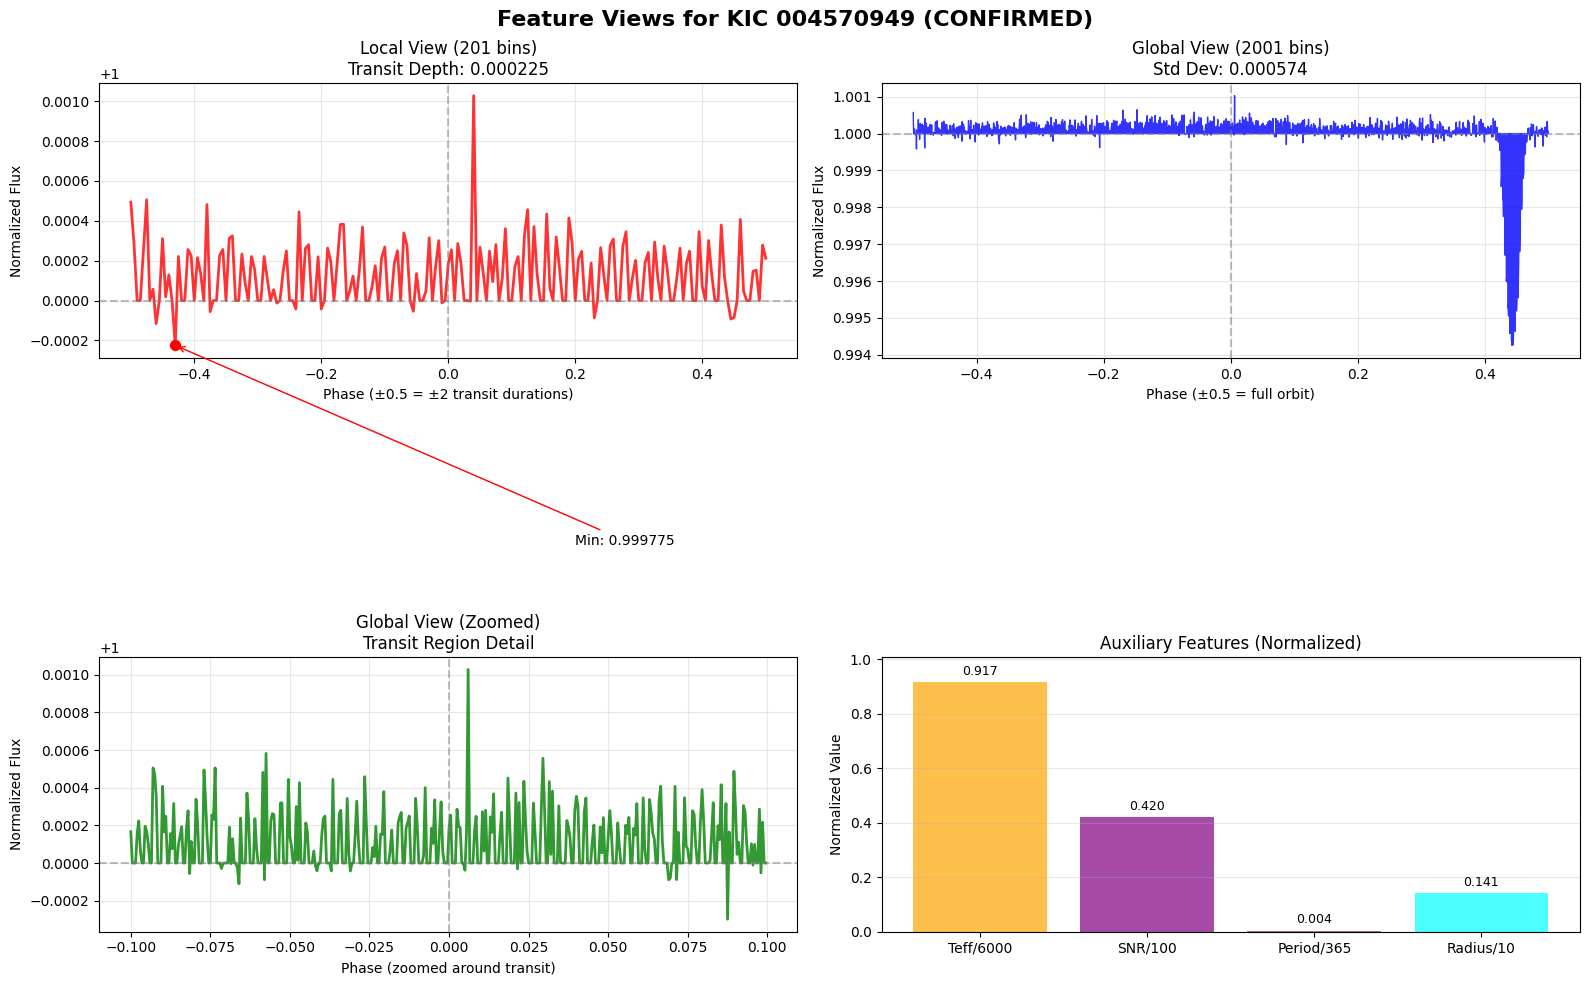


🔍 Detailed Feature Analysis for KIC 004570949:
   Local view range: 0.999775 - 1.001028
   Global view range: 0.994256 - 1.001028
   Transit depth: 0.000225 (0.0225%)
   Global variability: 0.000574
   Orbital period: 1.545 days
   Transit duration: 0.060 days (1.4 hours)


In [ ]:
# VISUALIZATION: Plot Local and Global Views from Feature Extraction
def plot_feature_views(features, kic_id, real_params, save_plot=False):
    """
    Create comprehensive plots of local and global views from extracted features.
    
    Args:
        features: Feature dictionary from KeplerFeatureExtractor
        kic_id: KIC identifier string
        real_params: Parameters used for feature extraction
        save_plot: Whether to save the plot to file
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'Feature Views for {kic_id} ({real_params["disposition"]})', 
                 fontsize=16, fontweight='bold')
    
    # Plot 1: Local View (Transit Region)
    local_phase = np.linspace(-0.5, 0.5, len(features['local_view']))
    axes[0,0].plot(local_phase, features['local_view'], 'r-', linewidth=2, alpha=0.8)
    axes[0,0].axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
    axes[0,0].axvline(x=0.0, color='gray', linestyle='--', alpha=0.5)
    axes[0,0].set_xlabel('Phase (±0.5 = ±2 transit durations)')
    axes[0,0].set_ylabel('Normalized Flux')
    axes[0,0].set_title(f'Local View (201 bins)\nTransit Depth: {1-features["local_view"].min():.6f}')
    axes[0,0].grid(True, alpha=0.3)
    
    # Highlight minimum (deepest transit point)
    min_idx = np.argmin(features['local_view'])
    min_phase = local_phase[min_idx]
    min_flux = features['local_view'][min_idx]
    axes[0,0].scatter([min_phase], [min_flux], color='red', s=50, zorder=5)
    axes[0,0].annotate(f'Min: {min_flux:.6f}', 
                      xy=(min_phase, min_flux), xytext=(0.2, min_flux-0.001),
                      arrowprops=dict(arrowstyle='->', color='red'))
    
    # Plot 2: Global View (Full Orbit)  
    global_phase = np.linspace(-0.5, 0.5, len(features['global_view']))
    axes[0,1].plot(global_phase, features['global_view'], 'b-', linewidth=1, alpha=0.8)
    axes[0,1].axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
    axes[0,1].axvline(x=0.0, color='gray', linestyle='--', alpha=0.5)
    axes[0,1].set_xlabel('Phase (±0.5 = full orbit)')
    axes[0,1].set_ylabel('Normalized Flux')
    axes[0,1].set_title(f'Global View (2001 bins)\nStd Dev: {features["global_view"].std():.6f}')
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Zoomed Global View around Transit
    # Focus on central 20% of global view
    center_start = int(0.4 * len(global_phase))
    center_end = int(0.6 * len(global_phase))
    zoom_phase = global_phase[center_start:center_end]
    zoom_flux = features['global_view'][center_start:center_end]
    
    axes[1,0].plot(zoom_phase, zoom_flux, 'g-', linewidth=2, alpha=0.8)
    axes[1,0].axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
    axes[1,0].axvline(x=0.0, color='gray', linestyle='--', alpha=0.5)
    axes[1,0].set_xlabel('Phase (zoomed around transit)')
    axes[1,0].set_ylabel('Normalized Flux')
    axes[1,0].set_title('Global View (Zoomed)\nTransit Region Detail')
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Auxiliary Features Visualization
    aux_features = features['aux_features']
    aux_labels = ['Teff/6000', 'SNR/100', 'Period/365', 'Radius/10']
    
    bars = axes[1,1].bar(aux_labels, aux_features, 
                        color=['orange', 'purple', 'brown', 'cyan'], alpha=0.7)
    axes[1,1].set_ylabel('Normalized Value')
    axes[1,1].set_title('Auxiliary Features (Normalized)')
    axes[1,1].grid(True, alpha=0.3, axis='y')
    axes[1,1].set_ylim(0, max(aux_features) * 1.1)
    
    # Add value labels on bars
    for bar, value in zip(bars, aux_features):
        height = bar.get_height()
        axes[1,1].annotate(f'{value:.3f}',
                          xy=(bar.get_x() + bar.get_width() / 2, height),
                          xytext=(0, 3), textcoords="offset points",
                          ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    
    if save_plot:
        plt.savefig(f'feature_views_{kic_id.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
        print(f"Plot saved as feature_views_{kic_id.replace(' ', '_')}.png")
    
    plt.show()
    
    # Print detailed analysis
    print(f"\n🔍 Detailed Feature Analysis for {kic_id}:")
    print(f"   Local view range: {features['local_view'].min():.6f} - {features['local_view'].max():.6f}")
    print(f"   Global view range: {features['global_view'].min():.6f} - {features['global_view'].max():.6f}")
    print(f"   Transit depth: {1 - features['local_view'].min():.6f} ({(1-features['local_view'].min())*100:.4f}%)")
    print(f"   Global variability: {features['global_view'].std():.6f}")
    print(f"   Orbital period: {real_params['period']:.3f} days")
    print(f"   Transit duration: {real_params['duration']:.3f} days ({real_params['duration']*24:.1f} hours)")

# Generate the plot if we have all the required data
if 'features_real' in globals() and 'kic_id' in globals() and 'real_params' in globals():
    print("📊 Creating Feature Views Visualization...")
    plot_feature_views(features_real, kic_id, real_params, save_plot=False)
else:
    print("⚠️  Required data not available. Run feature extraction first.")